In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm,tqdm_notebook
import albumentations as A
from albumentations.pytorch import ToTensorV2



In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.0.dev20221215+cu117


In [3]:
# Training settings
batch_size = 16
epochs = 30
lr = 3e-4
gamma = 0.7
seed = 42
re_mean_sd=False
need_test=False
debug_mode=False
image_size = 224


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data stream

In [6]:
os.makedirs('data', exist_ok=True)
images_dir = 'images/images'
train_list = glob.glob(os.path.join(images_dir,'*/*.jpg'))
if debug_mode:
    # keep only the first 100 images
    train_list = train_list[:100]
print(f"Number of total images: {len(train_list)}")

#split train and validation and test
train_list, test_list = train_test_split(train_list, test_size=0.1, random_state=seed)
train_list, val_list = train_test_split(train_list, test_size=0.1, random_state=seed)

print(f"Number of train images: {len(train_list)}")
print(f"Number of validation images: {len(val_list)}")
print(f"Number of test images: {len(test_list)}")

labels = [os.path.split(os.path.split(path)[0])[1] for path in train_list]
# kkep only unique labels
labels = list(set(labels))
print("The labels are:" ,labels)


Number of total images: 8446
Number of train images: 6840
Number of validation images: 761
Number of test images: 845
The labels are: ['Albrecht_Durer', 'Michelangelo', 'Gustave_Courbet', 'Mikhail_Vrubel', 'Paul_Gauguin', 'Raphael', 'Eugene_Delacroix', 'Paul_Cezanne', 'Alfred_Sisley', 'Andy_Warhol', 'Giotto_di_Bondone', 'Sandro_Botticelli', 'Vincent_van_Gogh', 'Camille_Pissarro', 'Salvador_Dali', 'Rene_Magritte', 'Peter_Paul_Rubens', 'Edouard_Manet', 'Henri_Matisse', 'Joan_Miro', 'Edvard_Munch', 'Diego_Rivera', 'Pablo_Picasso', 'Andrei_Rublev', 'Henri_Rousseau', 'Gustav_Klimt', 'Henri_de_Toulouse-Lautrec', 'Jackson_Pollock', 'El_Greco', 'Jan_van_Eyck', 'Leonardo_da_Vinci', 'Amedeo_Modigliani', 'Kazimir_Malevich', 'Paul_Klee', 'Georges_Seurat', 'Piet_Mondrian', 'Frida_Kahlo', 'Hieronymus_Bosch', 'Pierre-Auguste_Renoir', 'William_Turner', 'Pieter_Bruegel', 'Titian', 'Claude_Monet', 'Diego_Velazquez', 'Rembrandt', 'Caravaggio', 'Marc_Chagall', 'Vasiliy_Kandinskiy', 'Francisco_Goya', 'Edga

6840
[ 861 5391 5227 5192 3773 3093 5735 6266  467]


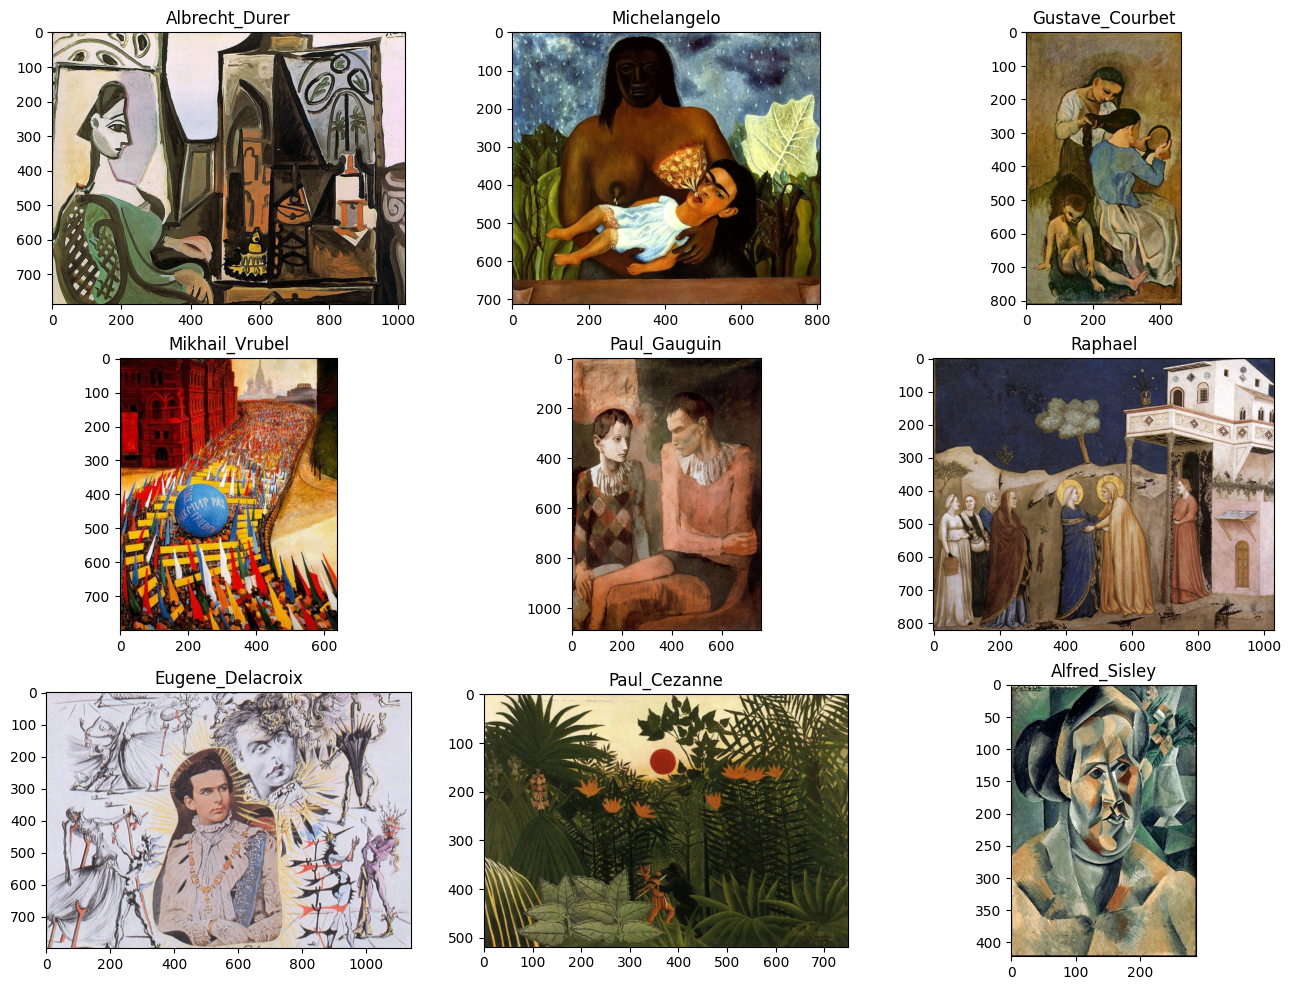

In [7]:
if not debug_mode:
    print(len(train_list))
    random_idx = np.random.randint(1, len(train_list), size=9)
    print(random_idx)
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))

    for idx, ax in enumerate(axes.ravel()):
        img = Image.open(train_list[idx])
        ax.set_title(labels[idx])
        ax.imshow(img)

In [8]:
if re_mean_sd:
    #extract mean and std from train set
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    train_dataset = datasets.ImageFolder(images_dir, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in tqdm(train_loader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
else:
    mean = [0.5035, 0.4448, 0.3722]
    std =  [0.2078, 0.1935, 0.1769]
print(f"mean: {mean}")
print(f"std: {std}")


mean: [0.5035, 0.4448, 0.3722]
std: [0.2078, 0.1935, 0.1769]


In [9]:

train_transforms = A.Compose(
    [
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        A.augmentations.Normalize(mean=mean, std=std),
        A.augmentations.geometric.rotate.RandomRotate90(),
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        A.augmentations.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)


test_transforms = A.Compose(
    [
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        A.augmentations.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)


In [10]:
class Create_dataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        # convert image to numpy array
        img = np.array(img)
        #if it is a grayscale image, repeat it 3 times
        if len(img.shape) == 2:
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        # apply transforms
        img = self.transform(image=img)
        img = img['image']
        #cast to tensor
        #if it is a grayscale image, repeat it 3 times

        label = os.path.split(os.path.split(img_path)[0])[1]
        # map label to index of labels
        label = labels.index(label)
        return img, label


In [11]:
# create dataset
train_dataset = Create_dataset(train_list, transform=train_transforms)
val_dataset = Create_dataset(val_list, transform=val_transforms)
test_dataset = Create_dataset(test_list, transform=test_transforms)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# print the sizes of train, validation and test
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 6840
Validation size: 761
Test size: 845


In [13]:
def train(model, device, train_loader,val_loader, epochs, output_folder):
    # loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    # optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)    
    # training loop
    best_accuracy = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):

            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(val_loader):

                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        filename="./trained_models/"+str(output_folder)
        # create folder if it does not exist
        if not os.path.exists(filename):
            os.makedirs(filename)
        if epoch_val_accuracy > best_accuracy:
            best_accuracy = epoch_val_accuracy
            filename="./trained_models/"+str(output_folder)+"/best.pt"
            torch.save(model.state_dict(), filename)
        filename="./trained_models/"+str(output_folder)+"/last.pt"
        torch.save(model.state_dict(), filename)
    # bring train_losses and val_losses to cpu
    train_losses = torch.stack(train_losses).cpu().detach().numpy()
    val_losses = torch.stack(val_losses).cpu().detach().numpy()
    return train_losses, val_losses

In [14]:
from sklearn.metrics import classification_report
def test_model(model_name, model, device, test_loader):
    model.load_state_dict(torch.load(model_name))
    print("Predictions: ")
    # load the best model
    model.load_state_dict(torch.load(str(model_name)))
    model.eval()
    # make predictions and extract the classificaiton report
    y_pred = []
    y_true = []
    for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            y_true.extend(label.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=labels))


### Ora si va ad addestrare i diversi modelli proposti via mail 
#### Quello che vogliamo fare è:
 - Addestrare prima su Resnet50 senza alcun pretraining
 - Addestrare prima su Resnet50 con pretraining
 - Addestrare Resnet50 eseguendo freezing layer di convoluzione
 - Addestrare Resnet50 eseguendo freezing layer dei primi layer di convoluzione
 - Addestrare Resnet50 modificata senza alcun pretraining
 - Addestrare Resnet50 modificata con pretraining
 - Addestrare Resnet50 modificata eseguendo freezing layer di convoluzione
 - Addestrare Resnet50 modificata eseguendo freezing layer dei primi layer di convoluzione

In [15]:
#import the needed libraries
import torchvision.models as models
from resnet import *
from torchsummary import summary
num_classes = len(labels)


#### Resnet50 scratch

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

c:\Users\lucaz\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_dynamo\eval_frame.py:433: UserWarning: Windows is not currently supported, torch._dynamo.optimize() will do nothing
  warnings.warn(
100%|██████████| 48/48 [00:27<00:00,  1.73it/s]


Epoch : 1 - loss : 3.3629 - acc: 0.1682 - val_loss : 3.0617 - val_acc: 0.2192



100%|██████████| 48/48 [00:16<00:00,  2.89it/s]


Epoch : 2 - loss : 2.9322 - acc: 0.2329 - val_loss : 2.8524 - val_acc: 0.2423



100%|██████████| 48/48 [00:16<00:00,  2.84it/s]


Epoch : 3 - loss : 2.7682 - acc: 0.2666 - val_loss : 2.6463 - val_acc: 0.3002



100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch : 4 - loss : 2.6654 - acc: 0.2827 - val_loss : 2.6801 - val_acc: 0.2781



100%|██████████| 48/48 [00:18<00:00,  2.67it/s]


Epoch : 5 - loss : 2.5737 - acc: 0.3026 - val_loss : 2.5506 - val_acc: 0.3158



100%|██████████| 48/48 [00:18<00:00,  2.64it/s]


Epoch : 6 - loss : 2.4583 - acc: 0.3376 - val_loss : 2.4098 - val_acc: 0.3419



100%|██████████| 48/48 [00:18<00:00,  2.56it/s]


Epoch : 7 - loss : 2.3735 - acc: 0.3544 - val_loss : 2.3607 - val_acc: 0.3650



100%|██████████| 48/48 [00:19<00:00,  2.43it/s]


Epoch : 8 - loss : 2.3185 - acc: 0.3684 - val_loss : 2.3184 - val_acc: 0.3536



100%|██████████| 48/48 [00:19<00:00,  2.51it/s]


Epoch : 9 - loss : 2.2426 - acc: 0.3862 - val_loss : 2.2468 - val_acc: 0.3754



100%|██████████| 48/48 [00:19<00:00,  2.45it/s]


Epoch : 10 - loss : 2.1829 - acc: 0.3959 - val_loss : 2.1839 - val_acc: 0.3937



100%|██████████| 48/48 [00:18<00:00,  2.64it/s]


Epoch : 11 - loss : 2.1424 - acc: 0.4057 - val_loss : 2.0566 - val_acc: 0.4356



100%|██████████| 48/48 [00:18<00:00,  2.59it/s]


Epoch : 12 - loss : 2.0536 - acc: 0.4327 - val_loss : 2.1173 - val_acc: 0.4311



100%|██████████| 48/48 [00:18<00:00,  2.53it/s]


Epoch : 13 - loss : 2.0342 - acc: 0.4314 - val_loss : 2.0516 - val_acc: 0.4379



100%|██████████| 48/48 [00:19<00:00,  2.45it/s]


Epoch : 14 - loss : 1.9559 - acc: 0.4518 - val_loss : 2.1182 - val_acc: 0.4181



100%|██████████| 48/48 [00:20<00:00,  2.37it/s]


Epoch : 15 - loss : 1.9052 - acc: 0.4673 - val_loss : 2.1107 - val_acc: 0.4350



100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Epoch : 16 - loss : 1.8447 - acc: 0.4883 - val_loss : 1.9568 - val_acc: 0.4650



100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Epoch : 17 - loss : 1.7987 - acc: 0.4901 - val_loss : 1.9382 - val_acc: 0.4702



100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Epoch : 18 - loss : 1.7012 - acc: 0.5177 - val_loss : 1.8922 - val_acc: 0.4624



100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch : 19 - loss : 1.6016 - acc: 0.5419 - val_loss : 1.9393 - val_acc: 0.4585



100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch : 20 - loss : 1.5967 - acc: 0.5410 - val_loss : 1.8063 - val_acc: 0.4897



100%|██████████| 48/48 [00:37<00:00,  1.27it/s]


Epoch : 21 - loss : 1.5281 - acc: 0.5605 - val_loss : 1.9043 - val_acc: 0.4702



100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Epoch : 22 - loss : 1.4262 - acc: 0.5834 - val_loss : 1.8081 - val_acc: 0.4999



100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Epoch : 23 - loss : 1.4208 - acc: 0.5882 - val_loss : 1.8527 - val_acc: 0.4842



100%|██████████| 48/48 [00:41<00:00,  1.16it/s]


Epoch : 24 - loss : 1.3392 - acc: 0.6059 - val_loss : 1.7903 - val_acc: 0.4939



100%|██████████| 48/48 [00:53<00:00,  1.11s/it]


Epoch : 25 - loss : 1.2416 - acc: 0.6374 - val_loss : 1.7197 - val_acc: 0.5132



100%|██████████| 48/48 [00:47<00:00,  1.01it/s]


Epoch : 26 - loss : 1.2002 - acc: 0.6500 - val_loss : 1.8318 - val_acc: 0.5204



100%|██████████| 48/48 [00:43<00:00,  1.11it/s]


Epoch : 27 - loss : 1.1361 - acc: 0.6723 - val_loss : 1.7646 - val_acc: 0.5155



100%|██████████| 48/48 [00:42<00:00,  1.12it/s]


Epoch : 28 - loss : 1.0882 - acc: 0.6874 - val_loss : 1.8968 - val_acc: 0.5077



100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Epoch : 29 - loss : 1.0113 - acc: 0.7014 - val_loss : 1.7812 - val_acc: 0.5132



100%|██████████| 48/48 [00:47<00:00,  1.01it/s]


Epoch : 30 - loss : 0.9230 - acc: 0.7300 - val_loss : 1.8951 - val_acc: 0.5106



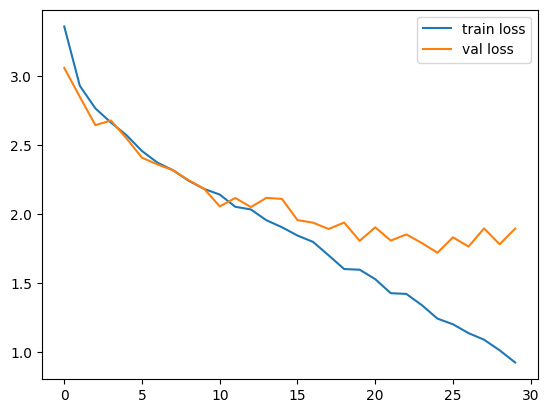

In [16]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = models.resnet50(weights=None)
# change the last layer
model.fc = nn.Linear(2048, num_classes)
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_from_scratch"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()


#### Resnet50 pretrained

c:\Users\lucaz\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_dynamo\eval_frame.py:433: UserWarning: Windows is not currently supported, torch._dynamo.optimize() will do nothing
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


Epoch : 1 - loss : 2.0868 - acc: 0.4582 - val_loss : 1.3935 - val_acc: 0.6220



100%|██████████| 48/48 [00:15<00:00,  3.15it/s]


Epoch : 2 - loss : 1.1234 - acc: 0.6796 - val_loss : 1.1503 - val_acc: 0.6806



100%|██████████| 48/48 [00:15<00:00,  3.09it/s]


Epoch : 3 - loss : 0.7855 - acc: 0.7677 - val_loss : 1.1034 - val_acc: 0.7056



100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch : 4 - loss : 0.5955 - acc: 0.8242 - val_loss : 1.0345 - val_acc: 0.7189



100%|██████████| 48/48 [00:16<00:00,  2.84it/s]


Epoch : 5 - loss : 0.4690 - acc: 0.8592 - val_loss : 0.9070 - val_acc: 0.7405



100%|██████████| 48/48 [00:16<00:00,  2.95it/s]


Epoch : 6 - loss : 0.3979 - acc: 0.8832 - val_loss : 1.0334 - val_acc: 0.7137



100%|██████████| 48/48 [00:17<00:00,  2.80it/s]


Epoch : 7 - loss : 0.3295 - acc: 0.9030 - val_loss : 0.9535 - val_acc: 0.7496



100%|██████████| 48/48 [00:17<00:00,  2.72it/s]


Epoch : 8 - loss : 0.2984 - acc: 0.9118 - val_loss : 0.9575 - val_acc: 0.7420



100%|██████████| 48/48 [00:18<00:00,  2.64it/s]


Epoch : 9 - loss : 0.2621 - acc: 0.9200 - val_loss : 0.9931 - val_acc: 0.7610



100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Epoch : 10 - loss : 0.2412 - acc: 0.9283 - val_loss : 0.9301 - val_acc: 0.7512



100%|██████████| 48/48 [00:18<00:00,  2.66it/s]


Epoch : 11 - loss : 0.2185 - acc: 0.9333 - val_loss : 1.0112 - val_acc: 0.7378



100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch : 12 - loss : 0.1887 - acc: 0.9441 - val_loss : 0.9834 - val_acc: 0.7433



100%|██████████| 48/48 [00:17<00:00,  2.72it/s]


Epoch : 13 - loss : 0.1969 - acc: 0.9391 - val_loss : 1.0631 - val_acc: 0.7342



100%|██████████| 48/48 [00:18<00:00,  2.66it/s]


Epoch : 14 - loss : 0.1830 - acc: 0.9451 - val_loss : 0.9455 - val_acc: 0.7600



100%|██████████| 48/48 [00:18<00:00,  2.66it/s]


Epoch : 15 - loss : 0.1604 - acc: 0.9512 - val_loss : 0.9820 - val_acc: 0.7756



100%|██████████| 48/48 [00:18<00:00,  2.58it/s]


Epoch : 16 - loss : 0.1646 - acc: 0.9501 - val_loss : 0.9767 - val_acc: 0.7574



100%|██████████| 48/48 [00:19<00:00,  2.48it/s]


Epoch : 17 - loss : 0.1302 - acc: 0.9593 - val_loss : 1.0707 - val_acc: 0.7496



100%|██████████| 48/48 [00:18<00:00,  2.62it/s]


Epoch : 18 - loss : 0.1380 - acc: 0.9568 - val_loss : 1.0331 - val_acc: 0.7642



100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch : 19 - loss : 0.1367 - acc: 0.9603 - val_loss : 0.9533 - val_acc: 0.7603



100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Epoch : 20 - loss : 0.1093 - acc: 0.9664 - val_loss : 0.9892 - val_acc: 0.7541



100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


Epoch : 21 - loss : 0.1361 - acc: 0.9588 - val_loss : 1.0209 - val_acc: 0.7587



100%|██████████| 48/48 [00:28<00:00,  1.66it/s]


Epoch : 22 - loss : 0.1232 - acc: 0.9616 - val_loss : 1.0360 - val_acc: 0.7459



100%|██████████| 48/48 [00:25<00:00,  1.88it/s]


Epoch : 23 - loss : 0.1151 - acc: 0.9648 - val_loss : 1.0564 - val_acc: 0.7470



100%|██████████| 48/48 [00:23<00:00,  2.00it/s]


Epoch : 24 - loss : 0.1083 - acc: 0.9671 - val_loss : 1.0840 - val_acc: 0.7486



100%|██████████| 48/48 [00:27<00:00,  1.73it/s]


Epoch : 25 - loss : 0.1047 - acc: 0.9657 - val_loss : 1.0021 - val_acc: 0.7710



100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Epoch : 26 - loss : 0.1081 - acc: 0.9644 - val_loss : 0.9789 - val_acc: 0.7558



100%|██████████| 48/48 [00:31<00:00,  1.52it/s]


Epoch : 27 - loss : 0.0898 - acc: 0.9731 - val_loss : 0.9804 - val_acc: 0.7548



100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Epoch : 28 - loss : 0.0979 - acc: 0.9699 - val_loss : 0.8942 - val_acc: 0.7792



100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Epoch : 29 - loss : 0.0859 - acc: 0.9755 - val_loss : 1.0116 - val_acc: 0.7600



100%|██████████| 48/48 [00:37<00:00,  1.26it/s]


Epoch : 30 - loss : 0.0839 - acc: 0.9746 - val_loss : 1.0208 - val_acc: 0.7717



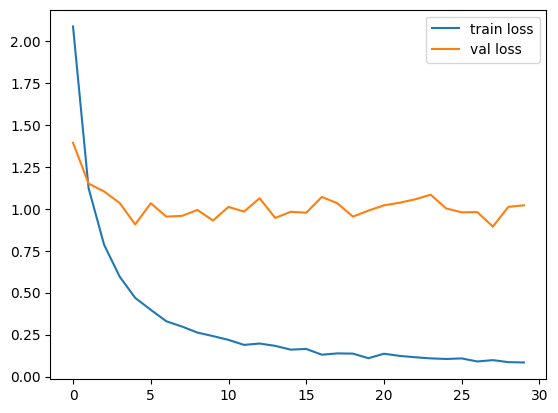

In [17]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# change the last layer
model.fc = nn.Linear(2048, num_classes)
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_from_scratch"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()

#### Resnet50 pretrained freeze all

c:\Users\lucaz\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_dynamo\eval_frame.py:433: UserWarning: Windows is not currently supported, torch._dynamo.optimize() will do nothing
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

100%|██████████| 48/48 [00:43<00:00,  1.09it/s]


Epoch : 1 - loss : 3.0284 - acc: 0.2488 - val_loss : 2.5394 - val_acc: 0.3993



100%|██████████| 48/48 [00:37<00:00,  1.29it/s]


Epoch : 2 - loss : 2.3018 - acc: 0.4449 - val_loss : 2.1083 - val_acc: 0.4983



100%|██████████| 48/48 [00:43<00:00,  1.11it/s]


Epoch : 3 - loss : 1.9562 - acc: 0.5326 - val_loss : 1.8860 - val_acc: 0.5425



100%|██████████| 48/48 [00:37<00:00,  1.28it/s]


Epoch : 4 - loss : 1.7438 - acc: 0.5860 - val_loss : 1.7180 - val_acc: 0.6008



100%|██████████| 48/48 [00:38<00:00,  1.26it/s]


Epoch : 5 - loss : 1.5807 - acc: 0.6195 - val_loss : 1.6124 - val_acc: 0.6063



100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Epoch : 6 - loss : 1.4703 - acc: 0.6430 - val_loss : 1.5426 - val_acc: 0.6230



100%|██████████| 48/48 [00:40<00:00,  1.17it/s]


Epoch : 7 - loss : 1.3654 - acc: 0.6671 - val_loss : 1.4741 - val_acc: 0.6412



100%|██████████| 48/48 [00:49<00:00,  1.03s/it]


Epoch : 8 - loss : 1.3000 - acc: 0.6771 - val_loss : 1.4201 - val_acc: 0.6425



100%|██████████| 48/48 [00:34<00:00,  1.38it/s]


Epoch : 9 - loss : 1.2074 - acc: 0.7058 - val_loss : 1.3796 - val_acc: 0.6438



100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch : 10 - loss : 1.1734 - acc: 0.7120 - val_loss : 1.3499 - val_acc: 0.6464



100%|██████████| 48/48 [00:37<00:00,  1.29it/s]


Epoch : 11 - loss : 1.1222 - acc: 0.7131 - val_loss : 1.3181 - val_acc: 0.6607



100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch : 12 - loss : 1.0524 - acc: 0.7490 - val_loss : 1.3000 - val_acc: 0.6701



100%|██████████| 48/48 [00:36<00:00,  1.33it/s]


Epoch : 13 - loss : 1.0128 - acc: 0.7532 - val_loss : 1.2622 - val_acc: 0.6607



100%|██████████| 48/48 [00:38<00:00,  1.25it/s]


Epoch : 14 - loss : 0.9785 - acc: 0.7628 - val_loss : 1.2557 - val_acc: 0.6780



100%|██████████| 48/48 [00:35<00:00,  1.37it/s]


Epoch : 15 - loss : 0.9330 - acc: 0.7668 - val_loss : 1.2381 - val_acc: 0.6701



100%|██████████| 48/48 [00:35<00:00,  1.33it/s]


Epoch : 16 - loss : 0.9199 - acc: 0.7729 - val_loss : 1.2169 - val_acc: 0.6698



100%|██████████| 48/48 [00:34<00:00,  1.41it/s]


Epoch : 17 - loss : 0.8742 - acc: 0.7929 - val_loss : 1.2130 - val_acc: 0.6780



100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch : 18 - loss : 0.8395 - acc: 0.7875 - val_loss : 1.1994 - val_acc: 0.6806



100%|██████████| 48/48 [00:30<00:00,  1.58it/s]


Epoch : 19 - loss : 0.8273 - acc: 0.7972 - val_loss : 1.1839 - val_acc: 0.6884



100%|██████████| 48/48 [00:30<00:00,  1.59it/s]


Epoch : 20 - loss : 0.8106 - acc: 0.8014 - val_loss : 1.1793 - val_acc: 0.6920



100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


Epoch : 21 - loss : 0.7874 - acc: 0.8075 - val_loss : 1.1742 - val_acc: 0.6832



100%|██████████| 48/48 [00:30<00:00,  1.58it/s]


Epoch : 22 - loss : 0.7698 - acc: 0.8039 - val_loss : 1.1571 - val_acc: 0.6959



100%|██████████| 48/48 [00:18<00:00,  2.60it/s]


Epoch : 23 - loss : 0.7337 - acc: 0.8182 - val_loss : 1.1542 - val_acc: 0.6923



100%|██████████| 48/48 [00:16<00:00,  2.86it/s]


Epoch : 24 - loss : 0.7246 - acc: 0.8218 - val_loss : 1.1506 - val_acc: 0.6897



100%|██████████| 48/48 [00:17<00:00,  2.77it/s]


Epoch : 25 - loss : 0.7117 - acc: 0.8258 - val_loss : 1.1439 - val_acc: 0.6832



100%|██████████| 48/48 [00:16<00:00,  2.98it/s]


Epoch : 26 - loss : 0.6860 - acc: 0.8343 - val_loss : 1.1450 - val_acc: 0.6832



100%|██████████| 48/48 [00:15<00:00,  3.17it/s]


Epoch : 27 - loss : 0.6733 - acc: 0.8370 - val_loss : 1.1437 - val_acc: 0.6936



100%|██████████| 48/48 [00:15<00:00,  3.15it/s]


Epoch : 28 - loss : 0.6762 - acc: 0.8265 - val_loss : 1.1398 - val_acc: 0.6975



100%|██████████| 48/48 [00:15<00:00,  3.14it/s]


Epoch : 29 - loss : 0.6507 - acc: 0.8367 - val_loss : 1.1273 - val_acc: 0.6923



100%|██████████| 48/48 [00:15<00:00,  3.14it/s]


Epoch : 30 - loss : 0.6315 - acc: 0.8459 - val_loss : 1.1212 - val_acc: 0.6962



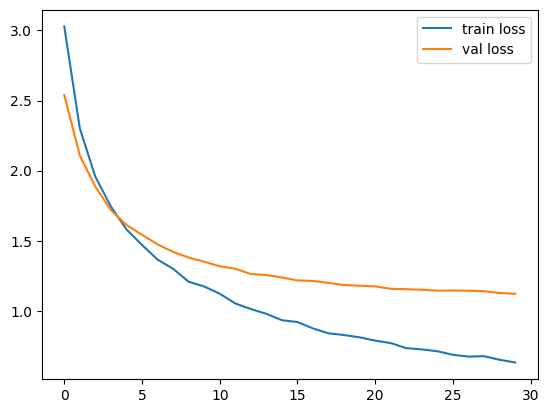

In [18]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# change the last layer
model.fc = nn.Linear(2048, num_classes)
#freeze all layers except the fully connected
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_pretrained_freeze_all"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()


#### Resnet50 pretrained freeze except last layer

c:\Users\lucaz\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_dynamo\eval_frame.py:433: UserWarning: Windows is not currently supported, torch._dynamo.optimize() will do nothing
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

100%|██████████| 48/48 [00:14<00:00,  3.22it/s]


Epoch : 1 - loss : 2.0998 - acc: 0.4534 - val_loss : 1.3703 - val_acc: 0.6262



100%|██████████| 48/48 [00:15<00:00,  3.18it/s]


Epoch : 2 - loss : 1.0423 - acc: 0.7036 - val_loss : 1.0928 - val_acc: 0.6978



100%|██████████| 48/48 [00:15<00:00,  3.19it/s]


Epoch : 3 - loss : 0.6904 - acc: 0.8015 - val_loss : 1.0255 - val_acc: 0.7183



100%|██████████| 48/48 [00:16<00:00,  2.94it/s]


Epoch : 4 - loss : 0.4707 - acc: 0.8607 - val_loss : 1.0112 - val_acc: 0.7251



100%|██████████| 48/48 [00:15<00:00,  3.11it/s]


Epoch : 5 - loss : 0.3823 - acc: 0.8873 - val_loss : 0.9854 - val_acc: 0.7376



100%|██████████| 48/48 [00:15<00:00,  3.14it/s]


Epoch : 6 - loss : 0.3014 - acc: 0.9109 - val_loss : 0.8691 - val_acc: 0.7610



100%|██████████| 48/48 [00:15<00:00,  3.11it/s]


Epoch : 7 - loss : 0.2261 - acc: 0.9353 - val_loss : 0.9329 - val_acc: 0.7613



100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch : 8 - loss : 0.2111 - acc: 0.9375 - val_loss : 1.0865 - val_acc: 0.7433



100%|██████████| 48/48 [00:18<00:00,  2.57it/s]


Epoch : 9 - loss : 0.1915 - acc: 0.9409 - val_loss : 0.9488 - val_acc: 0.7509



100%|██████████| 48/48 [00:15<00:00,  3.16it/s]


Epoch : 10 - loss : 0.1802 - acc: 0.9477 - val_loss : 1.0171 - val_acc: 0.7529



100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Epoch : 11 - loss : 0.1600 - acc: 0.9531 - val_loss : 1.0236 - val_acc: 0.7313



100%|██████████| 48/48 [00:16<00:00,  2.96it/s]


Epoch : 12 - loss : 0.1323 - acc: 0.9633 - val_loss : 1.0433 - val_acc: 0.7300



100%|██████████| 48/48 [00:15<00:00,  3.02it/s]


Epoch : 13 - loss : 0.1431 - acc: 0.9578 - val_loss : 0.9767 - val_acc: 0.7613



100%|██████████| 48/48 [00:19<00:00,  2.50it/s]


Epoch : 14 - loss : 0.1436 - acc: 0.9576 - val_loss : 1.0066 - val_acc: 0.7551



100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Epoch : 15 - loss : 0.1115 - acc: 0.9686 - val_loss : 1.0214 - val_acc: 0.7470



100%|██████████| 48/48 [00:16<00:00,  2.83it/s]


Epoch : 16 - loss : 0.1028 - acc: 0.9715 - val_loss : 0.9887 - val_acc: 0.7756



100%|██████████| 48/48 [00:18<00:00,  2.65it/s]


Epoch : 17 - loss : 0.1177 - acc: 0.9651 - val_loss : 0.9965 - val_acc: 0.7639



100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch : 18 - loss : 0.0965 - acc: 0.9731 - val_loss : 1.0037 - val_acc: 0.7665



100%|██████████| 48/48 [00:19<00:00,  2.51it/s]


Epoch : 19 - loss : 0.0903 - acc: 0.9712 - val_loss : 1.0116 - val_acc: 0.7704



100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Epoch : 20 - loss : 0.0999 - acc: 0.9695 - val_loss : 1.0489 - val_acc: 0.7662



100%|██████████| 48/48 [00:20<00:00,  2.31it/s]


Epoch : 21 - loss : 0.0766 - acc: 0.9762 - val_loss : 1.0194 - val_acc: 0.7548



100%|██████████| 48/48 [00:16<00:00,  2.89it/s]


Epoch : 22 - loss : 0.0833 - acc: 0.9755 - val_loss : 0.9701 - val_acc: 0.7649



100%|██████████| 48/48 [00:17<00:00,  2.80it/s]


Epoch : 23 - loss : 0.0749 - acc: 0.9787 - val_loss : 1.0214 - val_acc: 0.7782



100%|██████████| 48/48 [00:18<00:00,  2.58it/s]


Epoch : 24 - loss : 0.0690 - acc: 0.9793 - val_loss : 0.9971 - val_acc: 0.7678



100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch : 25 - loss : 0.0790 - acc: 0.9753 - val_loss : 0.9713 - val_acc: 0.7831



100%|██████████| 48/48 [00:20<00:00,  2.37it/s]


Epoch : 26 - loss : 0.0667 - acc: 0.9819 - val_loss : 1.0031 - val_acc: 0.7704



100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch : 27 - loss : 0.0770 - acc: 0.9778 - val_loss : 1.0588 - val_acc: 0.7509



100%|██████████| 48/48 [00:19<00:00,  2.48it/s]


Epoch : 28 - loss : 0.0654 - acc: 0.9790 - val_loss : 0.9247 - val_acc: 0.7701



100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch : 29 - loss : 0.0461 - acc: 0.9869 - val_loss : 1.0542 - val_acc: 0.7821



100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


Epoch : 30 - loss : 0.0566 - acc: 0.9812 - val_loss : 1.0531 - val_acc: 0.7701



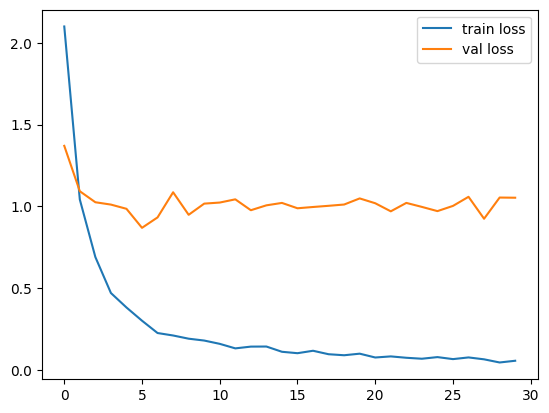

In [19]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# change the last layer
model.fc = nn.Linear(2048, num_classes)
#freeze all layers except the layers from the last block
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_pretrained_freeze_softer"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()

#### Resnet50 custom from scratch

In [20]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = ResNet50(num_classes=num_classes)
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_custom_from_scratch"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              GELU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
           Dropout-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
          Dropout-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

c:\Users\lucaz\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_dynamo\eval_frame.py:433: UserWarning: Windows is not currently supported, torch._dynamo.optimize() will do nothing
  warnings.warn(
100%|██████████| 48/48 [00:20<00:00,  2.38it/s]


Epoch : 1 - loss : 3.4469 - acc: 0.1424 - val_loss : 3.1676 - val_acc: 0.1830



100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch : 2 - loss : 3.0626 - acc: 0.2044 - val_loss : 2.9785 - val_acc: 0.1984



100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


Epoch : 3 - loss : 2.8591 - acc: 0.2433 - val_loss : 2.8330 - val_acc: 0.2504



100%|██████████| 48/48 [00:19<00:00,  2.47it/s]


Epoch : 4 - loss : 2.7015 - acc: 0.2801 - val_loss : 2.6660 - val_acc: 0.2944



100%|██████████| 48/48 [00:20<00:00,  2.40it/s]


Epoch : 5 - loss : 2.5727 - acc: 0.3065 - val_loss : 2.5893 - val_acc: 0.3155



100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


Epoch : 6 - loss : 2.4584 - acc: 0.3264 - val_loss : 2.3860 - val_acc: 0.3520



100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch : 7 - loss : 2.3622 - acc: 0.3480 - val_loss : 2.3335 - val_acc: 0.3830



100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Epoch : 8 - loss : 2.2669 - acc: 0.3751 - val_loss : 2.3180 - val_acc: 0.3683



100%|██████████| 48/48 [00:27<00:00,  1.77it/s]


Epoch : 9 - loss : 2.1634 - acc: 0.4030 - val_loss : 2.1937 - val_acc: 0.4096



100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch : 10 - loss : 2.1112 - acc: 0.4149 - val_loss : 2.1452 - val_acc: 0.4165



100%|██████████| 48/48 [00:24<00:00,  1.92it/s]


Epoch : 11 - loss : 2.0319 - acc: 0.4330 - val_loss : 2.0533 - val_acc: 0.4389



100%|██████████| 48/48 [00:25<00:00,  1.87it/s]


Epoch : 12 - loss : 1.9771 - acc: 0.4449 - val_loss : 2.0706 - val_acc: 0.4376



100%|██████████| 48/48 [00:26<00:00,  1.80it/s]


Epoch : 13 - loss : 1.9210 - acc: 0.4582 - val_loss : 2.0256 - val_acc: 0.4618



100%|██████████| 48/48 [00:25<00:00,  1.87it/s]


Epoch : 14 - loss : 1.8841 - acc: 0.4711 - val_loss : 2.0364 - val_acc: 0.4308



100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


Epoch : 15 - loss : 1.8391 - acc: 0.4766 - val_loss : 1.8954 - val_acc: 0.4764



100%|██████████| 48/48 [00:29<00:00,  1.60it/s]


Epoch : 16 - loss : 1.7507 - acc: 0.4977 - val_loss : 2.0425 - val_acc: 0.4653



100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Epoch : 17 - loss : 1.6911 - acc: 0.5136 - val_loss : 1.8516 - val_acc: 0.4965



100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Epoch : 18 - loss : 1.6635 - acc: 0.5222 - val_loss : 1.8578 - val_acc: 0.4832



100%|██████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch : 19 - loss : 1.6025 - acc: 0.5426 - val_loss : 1.7672 - val_acc: 0.5190



100%|██████████| 48/48 [00:34<00:00,  1.39it/s]


Epoch : 20 - loss : 1.5709 - acc: 0.5451 - val_loss : 1.8341 - val_acc: 0.5223



100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Epoch : 21 - loss : 1.5165 - acc: 0.5514 - val_loss : 1.7452 - val_acc: 0.5236



100%|██████████| 48/48 [00:42<00:00,  1.12it/s]


Epoch : 22 - loss : 1.4761 - acc: 0.5708 - val_loss : 1.7089 - val_acc: 0.5454



100%|██████████| 48/48 [00:51<00:00,  1.07s/it]


Epoch : 23 - loss : 1.4198 - acc: 0.5860 - val_loss : 1.6946 - val_acc: 0.5415



100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Epoch : 24 - loss : 1.3712 - acc: 0.5996 - val_loss : 1.7669 - val_acc: 0.5337



100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Epoch : 25 - loss : 1.3280 - acc: 0.6018 - val_loss : 1.6907 - val_acc: 0.5574



100%|██████████| 48/48 [00:55<00:00,  1.15s/it]


Epoch : 26 - loss : 1.3061 - acc: 0.6140 - val_loss : 1.7006 - val_acc: 0.5340



100%|██████████| 48/48 [01:03<00:00,  1.32s/it]


Epoch : 27 - loss : 1.2550 - acc: 0.6275 - val_loss : 1.7157 - val_acc: 0.5493



100%|██████████| 48/48 [01:33<00:00,  1.95s/it]


Epoch : 28 - loss : 1.2250 - acc: 0.6345 - val_loss : 1.6874 - val_acc: 0.5637



100%|██████████| 48/48 [01:04<00:00,  1.33s/it]


Epoch : 29 - loss : 1.1801 - acc: 0.6414 - val_loss : 1.6770 - val_acc: 0.5666



 52%|█████▏    | 223/428 [06:21<10:15,  3.00s/it]

#### Resnet50 custom pretrained 

In [ ]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = ResNet50(num_classes=num_classes)
PATH = "models/custom_resnet50.pt"
model.load_state_dict(torch.load(PATH), strict=True)
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_custom_pretrained"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()

#### Resnet50 custom pretrained freeze all

In [ ]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = ResNet50(num_classes=num_classes)
PATH = "models/custom_resnet50.pt"
model.load_state_dict(torch.load(PATH), strict=True)
#freeze all layers except the fully connected
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_custom_pretrained"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()

#### Resnet50 custom pretrained freeze except last layer

In [ ]:
#empty gpu cache
torch.cuda.empty_cache()
# create model 
model = ResNet50(num_classes=num_classes)
PATH = "models/custom_resnet50.pt"
model.load_state_dict(torch.load(PATH), strict=True)
#freeze all layers except the layers from the last block
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True
# print the model summary
summary(model.to('cpu'),  (3, 224, 224), device='cpu')
# move model to GPU if available and compile it thanks to torch 2.0
model = model.to(device)
model = torch.compile(model)
MODEL_PATH = "resnet50_custom_pretrained"
# train the model
train_losses, val_losses =train(model, device, train_loader, val_loader, epochs, MODEL_PATH)
#plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()
if need_test:
    # test the model
    BEST_MODEL_PATH = "./trained_models/"+str(MODEL_PATH)+"/best.pt"
    test_model(BEST_MODEL_PATH, model, device, test_loader)
del model
torch.cuda.empty_cache()